In [1]:
# Import all nessesary libraries
import json
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from itertools import combinations
import networkx as nx
import netwulf as nw
import community as community_louvain
from itertools import combinations

## Load Data

In [2]:
con_data = pd.read_csv('./Data/con_data.csv',low_memory = False)
con_data['Department'] = con_data['Department'].str.split(',').str[0]
con_data.fillna(0)
con_data.head()

,Department,ATC_ID,ATC5,Medicine_name,Generic_name,Trade_name,Date,Strength,Strength_measure,Type_of_Medicine,Way,Number_ordinations,Dosis,Dosis_measure,Adm_way,Key,Strength1,Strength2
0,AHOC,1217.0,C02AC01,CLONIDIN (LS) INJEKTIONSVÃ†SKE 150 MIKG/ML,Clonidin,Clonidin,2022-01-01,150,mikrog/ml,IntravenÃ¸s anvendelse,IP,1,75,mikrogram,0.0,0.0,_,NaN
1,AHOC,254.0,A04AA01,"ONDANSETRON INJ.VÃ†SKE, OPLÃ˜SNING 2 MG/ML",Ondansetron,Ondansetron,2022-01-01,2,MGM,IntravenÃ¸s anvendelse,IP,1,4,mg,IV,"['A04AA01', '2', 'MGM', 'IV']",_,NaN
2,AHOC,958.0,B05BB01,RINGER-LACTAT INFUSIONSVÃ†SKE OPL.,Elektrolytter,Elektrolytter,2022-01-01,NaN,NaN,IntravenÃ¸s anvendelse,IP,1,NaN,NaN,0.0,0.0,_,NaN
3,AHOC,3929.0,N01AH06,REMIFENTANIL (ONESTEP) 50 MIKROG/ML INFUSION,Remifentanil,NaN,2022-01-01,NaN,NaN,IntravenÃ¸s anvendelse,IP,1,NaN,NaN,0.0,0.0,_,NaN
4,AHOC,1099.0,C01CA03,NORADRENALIN 10 MIKROG/ML (ONESTEP) NACL ISOTO...,Noradrenalin,NaN,2022-01-01,NaN,NaN,IntravenÃ¸s anvendelse,IP,1,NaN,NaN,0.0,0.0,_,NaN


## Get Connections

In [3]:
def FindConnections(df, deps):
    Connections = {}
    for ATC in list(set(df['ATC5'])):
        Edges = []
        for dep in deps:
            df1 = df[df['Department'] == dep]
            df1_ATC = Counter(df1['ATC5'])
            if ATC in list(df1_ATC.keys()):
                a = [dep] * df1_ATC[ATC]
                Edges.extend(a)
            else:
                continue
        Connections[ATC] = Edges

    return Connections

In [4]:
Connections = FindConnections(con_data,list(set(con_data['Department'])))

## Get Network Attributes

In [5]:
def Get_Edges(Connections,deps):
    """ Compute which departments are two-and-two connected"""
    
    Edges = []
    for values in Connections.values():
        for dep in deps:
            if dep in list(set(values)):
                vals = set(values)
                vals.remove(dep)
                for dep1 in list(set(values)):
                    if dep1 in vals:
                        Edges.append(tuple(sorted([dep,dep1])))
                    else:
                        continue
            else:
                continue
    # Remove double. tripple etc. edges 
    Edges = set(Edges)
    
    return Edges

def GetLinkWeights(Edges, Connections):
    """
    Compute number of times two departments co-appear in relation to each ATC
    
    """
    
    Weights = {edge: 0 for edge in Edges}
    for edge in Weights.keys(): 
        w = 0
        for s in Connections.values(): 
            if (edge[0] in s) and (edge[1] in s): 
                w +=1
        Weights[edge] = w

    WeightsInput = [(key[0],key[1], {'weight': val}) for key, val in Weights.items()] 
    
    return WeightsInput

def GetNodeWeights(Connections):
    """
    Compute number of times the characters are mentioned
    
    """
    
    unique_characters = list(Connections.values())
    unique_characters = [item for sublist in unique_characters for item in sublist]
    count = Counter(unique_characters)
    count = dict(sorted(count.items(), key=lambda item: item[1],reverse = True))
    return count

## Build Network

In [6]:
def WeightedGraph(Connections): 
    """
    Uses NetworkX to build a Weighted Graph. 
    
    """
 
    # Compute node weights
    node_weight = GetNodeWeights(Connections)
    
    # Find links: 
    Edges = Get_Edges(Connections,list(set(con_data['Department'])))
    
    # Compute link weight
    link_weight = GetLinkWeights(Edges, Connections)
    
    # Initialise weighted graph
    G_W = nx.Graph()

    # Add nodes
    G_W.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None, size = None)

    # Add node size (weight)
    for key, val in node_weight.items(): 
        G_W.nodes[key]['size'] = val

    # Add links and weights
    G_W.add_edges_from(link_weight)
    
    return G_W

In [7]:
G_W = WeightedGraph(Connections)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61202)
Traceback (most recent call last):
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\http\server.py", line 651, in __init__
    super().__init__(*args, **kwargs)
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\Users\kcort\AppData\Local\Programs\Python\Python310\lib\http\s

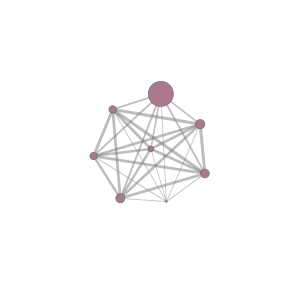

In [9]:
WGraphVisu, _ = nw.visualize(G_W)